In [2]:
from model import *
from helpers import *

from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize, LogNorm

In [17]:
# finds parameter combo where last snowball end time is within target time window

def search_end_time_target(
    initial_guess,
    other_params=None,
    target_time=(56, 59),
    step_C=0.1,
    step_tau=2.0,
    max_iter=25,
    verbose=True
):
    if other_params is None:
        other_params = {}

    tau = float(initial_guess['tau'])
    C_imb = float(initial_guess['C_imb'])

    history = []
    visited = set()

    for i in range(max_iter):
        params = {'C_imb': C_imb, 'tau': tau, **other_params}

        try:
            # run model and get last snowball end time
            results = run_model(**params)
            end_time = get_end_time(results)
            if verbose:
                print(f"[{i}] C_imb={C_imb:.4f}, tau={tau:.2f} → end_time={end_time:.2f} Myr")

            # check for convergence
            if target_time[0] <= end_time <= target_time[1]:
                if verbose:
                    print(f"\nSuccessful params: C_imb={C_imb:.3f}, tau={tau:.1f}, end_time={end_time:.2f}")
                return params, results, history

            # compute error from center of target range
            target_center = 0.5 * (target_time[0] + target_time[1])
            error = end_time - target_center

            # scale factor (large when far away, small when close)
            error_scale = (abs(error) / (target_time[1] - target_time[0])) ** 1.5

            # adaptive steps
            step_C_adapt = np.clip(error_scale * step_C, 0.001, 0.1)
            step_tau_adapt = np.clip(error_scale * step_tau, 0.05, 2.0)

            # track repetition
            history.append((C_imb, tau, end_time))
            rounded_key = (round(C_imb, 4), round(tau, 2))
            if rounded_key in visited:
                if verbose:
                    print("   Detected repetition — boosting step size to escape cycle")
                step_C_adapt *= np.random.uniform(2, 3.5)
                step_tau_adapt *= np.random.uniform(2, 3.5)
            else:
                visited.add(rounded_key)

            # directional update
            if error < 0:  # too early
                C_imb += step_C_adapt     # stronger forcing
                tau   += step_tau_adapt   # decays slower
            else:          # too late
                C_imb -= step_C_adapt     # weaker forcing
                tau   -= step_tau_adapt   # decays faster

        except Exception as e:
            if verbose:
                print(f"Failed at iteration {i} with C_imb={C_imb}, tau={tau}: {e}")
            break

    if history:
        best = min(history, key=lambda x: abs(x[2] - 0.5 * (target_time[0] + target_time[1])))
        best_C, best_tau, best_end = best
        if verbose:
            print(f"Best attempt: C_imb={best_C:.3f}, tau={best_tau:.2f}, end_time={best_end:.2f} Myr")
        best_params = {'C_imb': best_C, 'tau': best_tau, **other_params}
        return best_params, None, history
    else:
        if verbose:
            print("No valid model runs completed.")
        return None, None, history

In [18]:
# find best Cimb for a given tau such that snowball end time is around 56

def calibrate_Cimb_over_taus(
    taus,
    target=56.0,
    window=1.0,
    other_params={},
    step_C=0.1,
    step_tau=2.0,
    max_iter=25,
    t_max=100,
    verbose=True,
    Cimb_min=0.4
):

    target_time = (target - window, target + window)

    best_cimbs = []
    taus_out   = []
    durations  = []

    for tau in taus:
        # initial guess:
        C_imb_init = Cimb_min / np.exp(-target / tau)

        print(f"\nInitial tau = {tau:.2f} Myr, C_imb = {C_imb_init:.6f} ")

        # back off if the first model call blows up
        C_try = float(C_imb_init)
        backed_off = False
        for _ in range(5):
            try:
                _ = run_model(C_imb=C_try, tau=float(tau), t_max=t_max, **other_params)
                break
            except Exception as e:
                C_try *= 0.5
                backed_off = True
                if verbose:
                    print(f"  (backoff) initial run failed → halving C_imb to {C_try:.6f} ({e})")
        C_imb_init = C_try

        initial_guess = {'C_imb': float(C_imb_init), 'tau': float(tau)}

        params, results, history = search_end_time_target(
            initial_guess=initial_guess,
            other_params=other_params,
            target_time=target_time,
            step_C=step_C,
            step_tau=step_tau,
            max_iter=max_iter,
            verbose=verbose
        )

        if results is not None:
            end_time = get_end_time(results)
            C_imb_best = params['C_imb']
            print(f"Success: C_imb={C_imb_best:.6f}, end_time={end_time:.2f} Myr")
        else:
            C_imb_best = params['C_imb'] if params else np.nan
            end_time = np.nan
            print(f"Failed to converge: best C_imb≈{C_imb_best:.6f}")

        best_cimbs.append(float(C_imb_best) if np.isfinite(C_imb_best) else np.nan)
        taus_out.append(float(tau))
        durations.append(float(end_time) if np.isfinite(end_time) else np.nan)

    return best_cimbs, taus_out, durations

In [19]:
# find best cimbs

taus = [1,2,3,4,5,6,7,8,9,
        10,11,12,13,14,15,16,17,18,19,
        20,22,24,26,28,
        30,32,34,36,38,
        40,45,50,55,60,65,70,75,80]

best_cimbs, taus_out, durations = calibrate_Cimb_over_taus(
    taus,
    target=56.0,
    window=0.5,
    other_params={'dt': 1e4/1e6},
    verbose=False,
    Cimb_min=0.4
)


Initial tau = 1.00 Myr, C_imb = 836663798405198602305536.000000 
Failed to converge: best C_imb≈nan

Initial tau = 2.00 Myr, C_imb = 578502825716.590088 
Failed to converge: best C_imb≈nan

Initial tau = 3.00 Myr, C_imb = 51155262.809351 
Failed to converge: best C_imb≈nan

Initial tau = 4.00 Myr, C_imb = 481041.713666 
Failed to converge: best C_imb≈nan

Initial tau = 5.00 Myr, C_imb = 29252.176733 
Failed to converge: best C_imb≈nan

Initial tau = 6.00 Myr, C_imb = 4523.505844 
Failed to converge: best C_imb≈nan

Initial tau = 7.00 Myr, C_imb = 1192.383195 
Failed to converge: best C_imb≈74.865244

Initial tau = 8.00 Myr, C_imb = 438.653263 
Failed to converge: best C_imb≈109.845172

Initial tau = 9.00 Myr, C_imb = 201.528637 
Failed to converge: best C_imb≈100.864318

Initial tau = 10.00 Myr, C_imb = 108.170563 
Failed to converge: best C_imb≈108.289780

Initial tau = 11.00 Myr, C_imb = 65.015023 
Failed to converge: best C_imb≈65.193326

Initial tau = 12.00 Myr, C_imb = 42.537070 

In [48]:
def compute_and_report_LIP_volumes(
    taus,
    best_cimbs,
    other_params={},   # e.g., dict(dt=1e4/1e6, t_max=100, Pinorg_mode='scale', ...)
    Xm=10137,            # Ca+Mg mol/m^3 basalt
    verbose=True
):
    
    volumes_Mkm3 = []

    for tau, C_imb in zip(taus, best_cimbs):
        params = dict(other_params)  # copy
        params.update({'W_LIP': float(C_imb), 'tau': float(tau)})

        try:
            results = run_model(**params)
            t, vol_m3, height_m = LIP_volume(results, Xm=Xm, verbose=False)
            total_Mkm3 = vol_m3[-1] / 1e15  # m^3 → Mkm^3
        except Exception as e:
            if verbose:
                print(f"tau: {tau:.0f} Myr, C_imb: {float(C_imb):.2f} Emol/Myr, run failed")
            volumes_Mkm3.append(np.nan)
            continue

        volumes_Mkm3.append(float(total_Mkm3))
        if verbose:
            print(f"tau: {tau:.0f} Myr, C_imb: {float(C_imb):.2f} Emol/Myr, vol: {total_Mkm3:.1f} Mkm3")

    # --- drop NaNs ---
    taus_arr   = np.asarray(taus, float)
    cimbs_arr  = np.asarray(best_cimbs, float)
    vols_arr   = np.asarray(volumes_Mkm3, float)

    mask = np.isfinite(taus_arr) & np.isfinite(cimbs_arr) & np.isfinite(vols_arr)
    heights_final = None

    taus_final    = taus_arr[mask].tolist()
    cimbs_final   = cimbs_arr[mask].tolist()
    volumes_final = vols_arr[mask].tolist()

    return taus_final, cimbs_final, volumes_final


In [49]:
taus, cimbs, vols = compute_and_report_LIP_volumes(
    taus_out,
    best_cimbs,
    other_params={'dt': 1e4/1e6, 't_max': 100},
    Xm=10137,
    verbose=True
)

/Users/cminsky/Documents/Research/Sturtian-limit-cycles/ice_albedo.py:37: RuntimeWarning: divide by zero encountered in log
  get_T = lambda pCO2, albedo: interpolator(np.array([[np.log(pCO2), albedo]]))[0]


tau:    1 Myr, C_imb:   nan Emol/Myr,                nan  (run failed: division by zero)
tau:    2 Myr, C_imb:   nan Emol/Myr,                nan  (run failed: division by zero)
tau:    3 Myr, C_imb:   nan Emol/Myr,                nan  (run failed: division by zero)
tau:    4 Myr, C_imb:   nan Emol/Myr,                nan  (run failed: division by zero)
tau:    5 Myr, C_imb:   nan Emol/Myr,                nan  (run failed: division by zero)
tau:    6 Myr, C_imb:   nan Emol/Myr,                nan  (run failed: division by zero)
tau:    7 Myr, C_imb: 74.87 Emol/Myr, vol: 9.0 Mkm3
tau:    8 Myr, C_imb: 109.85 Emol/Myr, vol: 11.6 Mkm3
tau:    9 Myr, C_imb: 100.86 Emol/Myr, vol: 12.8 Mkm3
tau:   10 Myr, C_imb: 108.29 Emol/Myr, vol: 14.6 Mkm3
tau:   11 Myr, C_imb: 65.19 Emol/Myr, vol: 13.7 Mkm3
tau:   12 Myr, C_imb: 42.64 Emol/Myr, vol: 12.8 Mkm3
tau:   13 Myr, C_imb: 29.86 Emol/Myr, vol: 12.0 Mkm3
tau:   14 Myr, C_imb: 21.90 Emol/Myr, vol: 11.2 Mkm3
tau:   15 Myr, C_imb: 16.73 Emol/Myr, vo

C_imb=100.9 Tmol/yr, tau=9.0 Myr, vol=12.8 Mkm3
C_imb=1.0 Tmol/yr, tau=80.0 Myr, vol=5.1 Mkm3


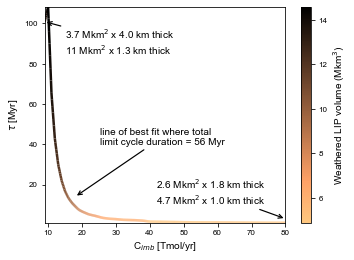

In [64]:
t = np.array(taus[2:])
c = np.array(cimbs[2:])
v = np.array(vols[2:])

# --- interpolate onto a dense grid ---
n_points = 500
ti = np.linspace(t.min(), t.max(), n_points)
ci = np.interp(ti, t, c)  # linear interpolation
vi = np.interp(ti, t, v)

# --- build colored line segments ---
pts = np.column_stack([ti, ci]).reshape(-1, 1, 2)
segs = np.concatenate([pts[:-1], pts[1:]], axis=1)

cmap = "copper_r"
log_c = False
if log_c and np.any(vi > 0):
    norm = LogNorm(vmin=np.nanmin(vi[vi > 0]), vmax=np.nanmax(vi[vi > 0]))
else:
    norm = Normalize(vmin=np.nanmin(vi), vmax=np.nanmax(vi))

lc = LineCollection(segs, cmap=cmap, norm=norm, linewidth=2.5)
lc.set_array(vi)  # color by volume

# --- plotting ---
fig = plt.figure(figsize=(4.18, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.add_collection(lc)
ax.set_xlim(ti.min(), ti.max())
ax.set_ylim(ci.min(), ci.max())

# axes + colorbar
ax.set_xlim(t.min(), t.max())
ax.set_ylabel("$\\tau$ [Myr]")
ax.set_xlabel("C$_{imb}$ [Tmol/yr]")

cbar = plt.colorbar(lc, ax=ax)
cbar.set_label("Weathered LIP volume (Mkm$^3$)")

# --- annotations ---

# left endpoint
print(f"C_imb={c[0]:.1f} Tmol/yr, tau={t[0]:.1f} Myr, vol={v[0]:.1f} Mkm3")
left_label  = "3.7 Mkm$^2$ x 4.0 km thick\n11 Mkm$^2$ x 1.3 km thick"
ax.annotate(
    left_label,
    xy=(ti[0], ci[0]), xycoords="data",
    xytext=(20, -5), textcoords="offset points",   # shorter offset
    ha="left", va="top",
    arrowprops=dict(arrowstyle="->", lw=1.2)
)

# right endpoint
print(f"C_imb={c[-1]:.1f} Tmol/yr, tau={t[-1]:.1f} Myr, vol={v[-1]:.1f} Mkm3")
right_label = "2.6 Mkm$^2$ x 1.8 km thick\n4.7 Mkm$^2$ x 1.0 km thick"
ax.annotate(
    right_label,
    xy=(ti[-1], ci[-1]+2), xycoords="data",
    xytext=(-20, 12), textcoords="offset points",  # shorter offset
    ha="right", va="bottom",
    arrowprops=dict(arrowstyle="->", lw=1.2)
)

# line
ax.annotate(
    "line of best fit where total \nlimit cycle duration = 56 Myr",
    xy=(18, 14), xycoords="data",
    xytext=(25, 50), textcoords="offset points",
    ha="left", va="bottom",
    #fontsize=10,
    arrowprops=dict(arrowstyle="->", lw=1.2)
)

figname="total_vol.pdf"
savefig(fig,figname,savefmt='pdf',supp_folder="supp")
plt.show()